# Eligibility Traces for Reinforcement Learning

We will now present another fundamental mechanism for Reinforcement Learning, the **eligibility trace**. These are methods that will allow us to generalize between TD and Monte Carlo methods, just like n-step TD methods did, but in addition they are a more elegant and computationally efficient solution. <br>

An *eligibility trace* $\textbf{z}_t$ acts as a **short-termed memory vector** that parallels the **long-term memory vector** represented by the weight vector $\textbf{w}_t$. The eligibility trace keeps track of which components of $\textbf{w}_t$ have contributed in producing the estimations. The "memory" stored in $\textbf{z}_t$ begins then to *fade away* with a speed proportional to a chosen parameter $\lambda$. Learning will then occour in the same component of $\textbf{w}_t$ if a *non-zero TD error* (the new estimation lead to an improvement of the target)*occours before the trace fades back to zero*. 
    
The main advantages offered by eligibility traces over $n$-step TD methods is that we *only need to store the eligibility trace* and not *the whole past experience* (the last $n$ feature vectors). In addition, learning occours uniformly during the whole episode, withouth the need of a "catching up" when we reach termination. Finally, learning occours immediatly after the observations are taken, without the need of dealying it for $n$ timesteps.


# Generalizing between TD and Monte Carlo methods

Before presenting methods using eligibility traces, we will show a first generalization between Temporal Difference methods and Monte Carlo methods obtained by using a particular type of target which, used in a normal function approximate framework, allows for a *smooth transitioning* between the two techniques: this is the so-called **$\lambda$-return**. <br> 

We start by noting that a valid update can be done not only towards any $n$-step return, but toward any **average** of $n$-step returns. We can then think of considering as target for our update not the $n$-step return but an *average of all the $n$-step returns*. This (paired with a normalization term so that the weighting of the returns sums up to one) is expressed by the formula:

$$ G_t^\lambda = (1 - \lambda) \sum_{n=1}^{+\infty} \lambda^{n-1} G_{t:t+n} $$

with all the $n$-step returns being $G_t$ after reaching the terminal state (for $t = T)$. From this expression it appears clear how by choosing $\lambda = 0$ the update will be a one-step TD method, while choosing $\lambda$ = 1 will result in a Monte Carlo method. <br>

In practice, we will have access to the $\lambda$-return only at the end of the episode. We can then naturally approximate this quantity by *truncating* the sequence after some number of steps. We define the **truncated $\lambda$-return** for time $t$, given data only up to some later horizon $h$:

$$ G_{t:h}^\lambda = (1 - \lambda) \sum_{n=1}^{h-t-1} \lambda^{n-1} G_{t:t+n}  + \lambda^{h-t-1} G_{t:h}, \quad 0 \leq t < h \leq T.$$

This update rule, along with the already known formulation for approximate methods already gives us a first algorithm, the so-called *off-line $\lambda$-return algorithm*. All we have to do is to write the update rule for the function approximator's weights using the $lambda$-return, givin us the following:

$$ \textbf{w}_{t+1} = \textbf{w}_t + \alpha \left[ G_{t:h}^\lambda - \hat{v}(S_t, \textbf{w}_t) \right] \nabla \hat{v}(S_t, \textbf{w}_t), \quad t = 0, \dots, T-1$$ 


## TD($\lambda$)

Now we will present the fist way to implement eligibility traces in an algorithm. <br>
Consider the same exact framework as the off-line $\lambda$-return algorithm. Introducing the eligibility trace, it's gonna be a vector $\textbf{z}_t \in \mathbb{R}^d$ with the same number of components as $\textbf{w}_t$. As we introduced before, we want the trace to act as *short-term memory vector*, recording which components of $\textbf{w}_t$ have *recently contributed in the update of the value function* (positively or negatively). Finally, we want to use this stored information to impact how the weights are updated, which, in turn, will produce a new estimation of the value function. <br>

Translating what stated above in formulae, we will initialize (before the episode) the trace to zero ($\textbf{z}_{-1} = \textbf{0}$). Then, in each timestep, the trace is incremented by the **gradient of the value function** and the **fades away** by $\gamma \lambda$, where $\gamma$ is the discount rate. 

$$ \textbf{z}_t = \gamma \lambda \textbf{z}_{t-1} + \nabla \hat{v}(S_t, \textbf{w}_t), \quad 0 \leq t \leq T$$

We first note that the "recency" of the events recorded by the trace is determined by the factor $\gamma \lambda$. Secondly, we can thus reformulate the purpose of the trace as *indicating the eligibility of each component of the weight vector for undergoing learning changes should a reinforcing event occour*.

**TODO: Insert elitrace pic**

The reinforcing events we are concerned with are the *one-step TD errors*. For state-value predictions:

$$ \delta_t = R_{t+1} +\gamma \hat{v}(S_{t+1}, \textbf{w}_t) - \hat{v}(S_t, \textbf{w}_t) $$ 

Finally, the weight vector is updated on each step porportionally to the obtained TD error weighted by the eligibility trace:

$$ \textbf{w}_{t+1} = \textbf{w}_{t} + \alpha \delta_t \textbf{z}_{t} $$

With the introduction of the eligibility trace, TD($\lambda$) manages to improve the offline $\lambda$-return algorithm in three ways:
- It updates the weight vector on every step of the episode and not only at the end, thus having access to the estimations way sooner;
- Computations are distributed equally in time rather than being all concentrated at the end of the episode;
- It can be applied also to continuing problems rather than only episodic ones.


## Forward and Backward View

Now that we presented two algorithms, we can distinguish between two approaches: the *forward view* and the *backward view*.

The usual approach (the one encountered so far) is what is called a **forward view** of an algorithm: for each state visited we look forward to the future rewards and decide how to best combine them. 

**TODO: forward view megaphone guy pic**

TD($\lambda$) is the first example of an algorithm that as a **backward view** instead: at each moment we look at the current TD error and assign it backward to each prior state according to how much that state contributed to the current eligibility trace at that time. 

**TODO: backward view megaphone guy pic**

To understand this definition, consider the case $\lambda = 0$: in this case the trace at every timstep is simply the gradient of the value function evaluated in the encountered state $S_t$. Thus the TD($\lambda$) update is reduced to the one-step TD update. For larger values of $\lambda$, with $\lambda < 1$, mor eof the preceeding states are changed, but the more distant they are from the present *the less credit* is given to them for the TD error. 


# True Online Methods

As we mentioned, we will usually truncate the $\lambda$-return so to not have to wait the end of the episode to produce the estimates. This involves a tradeoff: we should choose a truncation threshold $n$ large enough to allow the method approximate the untruncated return, but it should also be small enough to allow for sooner updates so that the algorithm's behaviour can be influenced early. <br>
One idea to combine these two methods is to *redo all the updates since the beginning of the episode* at every increment of the data. That is, *the updates are always towards an n-step truncated λ-return target, but they always use the latest horizon*. Doing this implies multiple passes over the same episode, with each pass generating a new sequence of weights. We will distinguish them by denoting as $\textbf{w}_t^h$ the weight used to generate the value estimation at time $t$ and with horizon $h$. By doing some calculations, one can derive the following update rule 

$$ \textbf{w}_{t+1}^h = \textbf{w}_{t}^h + \alpha \left[ G_{t:h}^\lambda - \hat{v} (S_t, \textbf{w}_{t}^h) \right] \nabla \hat{v} (S_t, \textbf{w}_{t}^h), \quad 0 \leq t < h \leq T.$$

This rule, together with $\textbf{w}_t = \textbf{w}_t^t$, defines the **online $\lambda$-return algorithm**. 

## True Online TD($\lambda$)

Naturally, we would like to extend the result presented above the the TD($\lambda$) algorithm. It can be shown that this is not only possible, but that is also possible to derive an update rule which acts *sequentially*, i.e. by using each weight vector computed along the way, $\textbf{w}_t^t$, to bootstrap the $n$-step returns in the update. Assuming the use of a linear approximator ($\hat{v}(s, \textbf{w}) = \textbf{w}^T \textbf{x}(s)$), and ignoring for easyness of notation the superscripts, this rule is expressed as

$$ \textbf{w}_{t+1} = \textbf{w}_t + \alpha \delta_t \textbf{z}_t + \alpha ( \textbf{w}^T\textbf{x}_t - \textbf{w}_{t-1}^T \textbf{x}_t)(\textbf{z}_t - \textbf{x}_t) $$

where we used the shorthand $\textbf{x}_t = \textbf{x}_t (S_t)$ and with $\delta_t$ as defined for the standard TD($\lambda$) algorithm. The eligibility trace is defined as:

$$ \textbf{z}_t = \gamma \lambda \textbf{z}_{t-1} + (1 - \alpha \gamma \textbf{z}_{t-1}^T \textbf{x}_t) \textbf{x}_t $$

## SARSA($\lambda$)

Again, the exstension of the algorithm presented above to optimal policy control is quite direct. The only step needed is the substition in all the formulae of the state value $\hat{v}(s, \textbf{w})$ with the action value $\hat{q}(s,a,\textbf{w})$. By doing this substitution, we immediatly have at our disposal the SARSA($\lambda$) and the True Online SARSA($\lambda$) algorithms.

In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import gym

import utils
from tileEncoder import TileEncoder
from agents import TrueOnlineLambdaSARSA

# Experiments 

Below we train the True Online n-step SARSA the OpenAI Mountain Car environment, as already presented in the Approximate Methods notebook. In this notebook we will use an $\epsilon$-greedy policy, with $\epsilon = 0.1$ held constant, unless noted otherwise. We encode the state space using tile coding, using $m=8$ tilings and $n=8$ bins for each tiling.

During training we monitor

- The cost-to-go function, intended as $- \max_a \hat{q}(s,a,\textbf{w})$

In addition, we render a full episode until termination after every 100 episodes. 

In [3]:
## Run settings
num_runs = 5  # Number of runs to average rewards over
eps_per_run = 600  # Number of episodes (terminations) per run
n = 8  # n parameter in n-step Bootstrapping

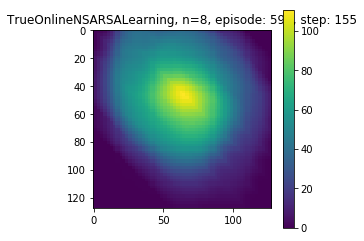

In [4]:
TrueNSARSALearning_rewards = []
TrueNSARSALearning_eplen = []
nbins = 8
ntiles = 8
env = TileEncoder(gym.make('MountainCar-v0'),nbins=nbins,ntiles=ntiles)
for i in range(num_runs):
    TrueNSARSA_Learning = TrueOnlineLambdaSARSA(env.obspace_shape(), env.nactions(), n=n)
    ep_lens, rewards = utils.approx_run_loop(env, TrueNSARSA_Learning, 'TrueOnlineNSARSALearning, n='+str(n), max_e=eps_per_run)
    TrueNSARSALearning_rewards.append(rewards)
    TrueNSARSALearning_eplen.append(ep_lens)

TrueNSARSALearning_rewards  = np.array(TrueNSARSALearning_rewards)
TrueNSARSALearning_eplen = np.array(TrueNSARSALearning_eplen)
env.close()

# Discussion

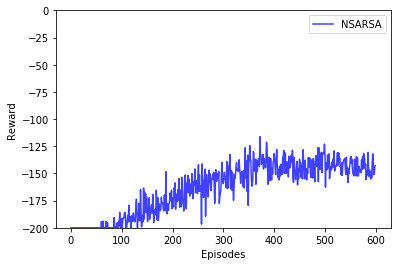

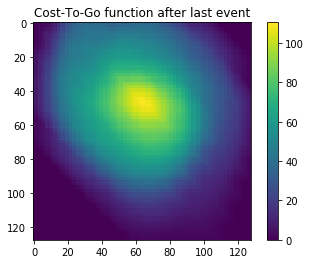

In [5]:
plt.figure()
utils.reward_plotter(TrueNSARSALearning_rewards, 'NSARSA', 'b')

axes = plt.gca()
axes.set_ylim([-200, 0])

plt.show()

plt.figure()
plt.imshow(utils.costToGo(128,env,TrueNSARSA_Learning))
plt.title("Cost-To-Go function after last event")
plt.colorbar()

# Bibliographic Notes

[1] Richard S. Sutton and Andrew G. Barto. 1998. Introduction to Reinforcement Learning (1st ed.). MIT Press, Cambridge, MA, USA.